# Adversarial Training on GCP

Author: Anya Trivedi

In [ ]:
#Based on GCP's original Income-Census Notebook

# Copyright 2019 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### **Dataset**

This project uses the MNIST datast for image classification, in a [CSV format](https://github.com/aashka-trivedi/cloud-autoai-adversarial-robustness/tree/master/data_compressed). Adversarial examples are geneerated using an FGSM attack. IMPORTANT: store all CSV files in the project bucket, ensure region is us-central.

### **GCP Plugins**


This project uses billable components of Google Cloud Platform (GCP):

* Cloud AI Platform
* Cloud Storage
* AutoML Tables


## **Set up your local development environment**

**If you are using Colab or AI Platform Notebooks**, your environment already meets
all the requirements to run this notebook. If you are using **AI Platform Notebook**, make sure the machine configuration type is **1 vCPU, 3.75 GB RAM** or above. You can skip this step.

**Otherwise**, make sure your environment meets this notebook's requirements.
You need the following:

* The Google Cloud SDK
* Git
* Python 3
* virtualenv
* Jupyter notebook running in a virtual environment with Python 3

The Google Cloud guide to [Setting up a Python development
environment](https://cloud.google.com/python/setup) and the [Jupyter
installation guide](https://jupyter.org/install) provide detailed instructions
for meeting these requirements. The following steps provide a condensed set of
instructions:

1. [Install and initialize the Cloud SDK.](https://cloud.google.com/sdk/docs/)

2. [Install Python 3.](https://cloud.google.com/python/setup#installing_python)

3. [Install
   virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv)
   and create a virtual environment that uses Python 3.

4. Activate that environment and run `pip install jupyter` in a shell to install
   Jupyter.

5. Run `jupyter notebook` in a shell to launch Jupyter.

6. Open this notebook in the Jupyter Notebook Dashboard.

## **Set up your GCP project**

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a GCP project.](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the AI Platform APIs and Compute Engine APIs.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component)

4. [Enable AutoML API.](https://console.cloud.google.com/apis/library/automl.googleapis.com?q=automl)


### **PIP Install Packages and dependencies**

Install addional dependencies not installed in Notebook environment


In [1]:
# Use the latest major GA version of the framework.
! pip install --upgrade --quiet --user --user google-cloud-automl

**Note:** Try installing using `sudo`, if the above command throw any permission errors.

`Restart` the kernel to allow automl_v1beta1 to be imported for Jupyter Notebooks.

In [2]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

## **Set up your GCP Project Id**

Enter your `Project Id` in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

In [3]:
PROJECT_ID = "cml-adversary-classification" #@param {type:"string"}
COMPUTE_REGION = "us-central1" # Currently only supported region.

## **Authenticate your GCP account**

**If you are using AI Platform Notebooks**, your environment is already
authenticated. Skip this step.

Otherwise, follow these steps:

1. In the GCP Console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

2. From the **Service account** drop-down list, select **New service account**.

3. In the **Service account name** field, enter a name.

4. From the **Role** drop-down list, select
   **AutoML > AutoML Admin** and
   **Storage > Storage Object Admin**.

5. Click *Create*. A JSON file that contains your key downloads to your
local environment.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

In [ ]:
# # Upload the downloaded JSON file that contains your key.
# import sys

# if 'google.colab' in sys.modules:    
#   from google.colab import files
#   keyfile_upload = files.upload()
#   keyfile = list(keyfile_upload.keys())[0]
#   %env GOOGLE_APPLICATION_CREDENTIALS $keyfile
#   ! gcloud auth activate-service-account --key-file $keyfile

***If you are running the notebook locally***, enter the path to your service account key as the `GOOGLE_APPLICATION_CREDENTIALS` variable in the cell below and run the cell

In [ ]:
# If you are running this notebook locally, replace the string below with the
# path to your service account key and run this cell to authenticate your GCP
# account.

# %env GOOGLE_APPLICATION_CREDENTIALS /path/to/service/account
# ! gcloud auth activate-service-account --key-file '/path/to/service/account'

## **Create a Cloud Storage bucket**

**The following steps are required, regardless of your notebook environment.**

When you submit a training job using the Cloud SDK, you upload a Python package
containing your training code to a Cloud Storage bucket. AI Platform runs
the code from this package. In this tutorial, AI Platform also saves the
trained model that results from your job in the same bucket. You can then
create an AI Platform model version based on this output in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets. 

You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Cloud
AI Platform services are
available](https://cloud.google.com/ml-engine/docs/tensorflow/regions). You may
not use a Multi-Regional Storage bucket for training with AI Platform.

In [4]:
BUCKET_NAME = "cml-project-bucket" #@param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket. Make sure Storage > Storage Admin role is enabled

In [ ]:
# ! gsutil mb -p $PROJECT_ID -l $COMPUTE_REGION gs://$BUCKET_NAME

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [5]:
! gsutil ls -al gs://$BUCKET_NAME

  40669536  2021-11-28T01:11:01Z  gs://cml-project-bucket/mnist_test_pytorch.csv#1638061861177227  metageneration=1
 243738075  2021-11-28T01:13:30Z  gs://cml-project-bucket/mnist_train_pytorch.csv#1638062010989555  metageneration=1
TOTAL: 2 objects, 284407611 bytes (271.23 MiB)


## **Import libraries and define constants**

Import relevant packages.

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [16]:
# AutoML library.
from google.cloud import automl_v1beta1 as automl
#import google.cloud.automl_v1beta1.proto.data_types_pb2 as data_types

import google.cloud.automl_v1beta1.types as data_types

In [24]:
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

Populate the following cell with the necessary constants and run it to initialize constants.

In [8]:
#@title Constants { vertical-output: true }

# A name for the AutoML tables Dataset to create.
DATASET_DISPLAY_NAME = 'mnist' #@param {type: 'string'}
# The GCS data to import data from (doesn't need to exist).
INPUT_CSV_NAME = 'mnist_train_pytorch' #@param {type: 'string'}
# A name for the AutoML tables model to create.
MODEL_DISPLAY_NAME = 'mnist_image_classification_model' #@param {type: 'string'}

assert all([
    PROJECT_ID,
    COMPUTE_REGION,
    DATASET_DISPLAY_NAME,
    INPUT_CSV_NAME,
    MODEL_DISPLAY_NAME,
])

Initialize client for AutoML and AutoML Tables

In [9]:
# Initialize the clients.
automl_client = automl.AutoMlClient()
tables_client = automl.TablesClient(project=PROJECT_ID, region=COMPUTE_REGION)

## **Test the set up**

To test whether your project set up and authentication steps were successful, run the following cell to list your datasets in this project.

If no dataset has previously imported into AutoML Tables, you shall expect an empty return.

In [10]:
# List the datasets.
list_datasets = tables_client.list_datasets()
datasets = { dataset.display_name: dataset.name for dataset in list_datasets }
datasets

{'images': 'projects/887578167092/locations/us-central1/datasets/TBL2213040379538702336'}

You can also print the list of your models by running the following cell.
​
If no model has previously trained using AutoML Tables, you shall expect an empty return.

In [11]:
# List the models.
list_models = tables_client.list_models()
models = { model.display_name: model.name for model in list_models }
models

{}

## **Import training data**

### **Create dataset**
Now we are ready to create a dataset instance (on GCP) using the client method `create_dataset()`. This method has one required parameter, the human readable display name `DATASET_DISPLAY_NAME`.

Select a dataset display name and pass your table source information to create a new dataset.

In [12]:
# Create dataset.
dataset = tables_client.create_dataset(
          dataset_display_name=DATASET_DISPLAY_NAME)
dataset_name = dataset.name
dataset

name: "projects/887578167092/locations/us-central1/datasets/TBL1145124317898473472"
display_name: "mnist"
create_time {
  seconds: 1638195749
  nanos: 53108000
}
etag: "AB3BwFpHbB6pS4no1Q-n82xpglTHa2fWKnsXaJRntphHNoDLukUE8JGb5y10q-0oOcI="
tables_dataset_metadata {
  stats_update_time {
  }
}

### **Import data**

You can import your data to AutoML Tables from GCS or BigQuery. This project uses csv files *already uploaded* into the project bucket.

In [13]:
GCS_DATASET_URI = 'gs://{}/{}.csv'.format(BUCKET_NAME, INPUT_CSV_NAME)
! gsutil ls gs://$BUCKET_NAME || gsutil mb -l $COMPUTE_REGION gs://$BUCKET_NAME
! gsutil cp gs://cml-project-bucket/mnist_train_pytorch.csv $GCS_DATASET_URI

gs://cml-project-bucket/mnist_test_pytorch.csv
gs://cml-project-bucket/mnist_train_pytorch.csv
Copying gs://cml-project-bucket/mnist_train_pytorch.csv [Content-Type=text/csv]...
/ [1 files][232.4 MiB/232.4 MiB]                                                
Operation completed over 1 objects/232.4 MiB.                                    


Import data into the dataset, this process may take a while, depending on your data, once completed, you can verify the status by printing the dataset object. 

In [14]:
# Read the data source from GCS. 
import_data_response = tables_client.import_data(
    dataset=dataset,
    gcs_input_uris=GCS_DATASET_URI
)
print('Dataset import operation: {}'.format(import_data_response.operation))

# Synchronous check of operation status. Wait until import is done.
print('Dataset import response: {}'.format(import_data_response.result()))

# Verify the status by checking the example_count field.
dataset = tables_client.get_dataset(dataset_name=dataset_name)
dataset

Dataset import operation: name: "projects/887578167092/locations/us-central1/operations/TBL519206158188150784"
metadata {
  type_url: "type.googleapis.com/google.cloud.automl.v1beta1.OperationMetadata"
  value: "\032\013\010\320\304\223\215\006\020\360\351\215\003\"\013\010\320\304\223\215\006\020\360\351\215\003z\000"
}

Dataset import response: 


name: "projects/887578167092/locations/us-central1/datasets/TBL1145124317898473472"
display_name: "mnist"
create_time {
  seconds: 1638195749
  nanos: 53108000
}
etag: "AB3BwFqbhvuEPM5H0DPvOQsitJ5jQMbmD2mFVLkczH1sfcM5fyWtH4As0kTdZhUFgfLH"
example_count: 58870
tables_dataset_metadata {
  primary_table_spec_id: "5939645376129662976"
  stats_update_time {
    seconds: 1638196038
    nanos: 306218000
  }
}

## **Review the specs**

Run the following command to see table specs such as row count, and Data Type of the features

In [20]:
# List table specs.
list_table_specs_response = tables_client.list_table_specs(dataset=dataset)
table_specs = [s for s in list_table_specs_response]

# List column specs.
list_column_specs_response = tables_client.list_column_specs(dataset=dataset)
column_specs = {s.display_name: s for s in list_column_specs_response}

# Print Features and data_type.
# CHANGE the typeCode.Name to just Typecode according to https://googleapis.dev/python/automl/latest/_modules/google/cloud/automl_v1beta1/types/data_types.html
#features = [(key, data_types.TypeCode.Name(value.data_type.type_code)) 
            # for key, value in column_specs.items()]
features = [(key, data_types.TypeCode(value.data_type.type_code)) 
            for key, value in column_specs.items()]
print('Feature list:\n')
for feature in features:
    print(feature[0],':', feature[1])

Feature list:

label : TypeCode.CATEGORY
1 : TypeCode.CATEGORY
2 : TypeCode.CATEGORY
3 : TypeCode.CATEGORY
4 : TypeCode.CATEGORY
5 : TypeCode.CATEGORY
6 : TypeCode.CATEGORY
7 : TypeCode.CATEGORY
8 : TypeCode.CATEGORY
9 : TypeCode.CATEGORY
10 : TypeCode.CATEGORY
11 : TypeCode.CATEGORY
12 : TypeCode.CATEGORY
13 : TypeCode.CATEGORY
14 : TypeCode.CATEGORY
15 : TypeCode.CATEGORY
16 : TypeCode.CATEGORY
17 : TypeCode.CATEGORY
18 : TypeCode.CATEGORY
19 : TypeCode.CATEGORY
20 : TypeCode.CATEGORY
21 : TypeCode.CATEGORY
22 : TypeCode.CATEGORY
23 : TypeCode.CATEGORY
24 : TypeCode.CATEGORY
25 : TypeCode.CATEGORY
26 : TypeCode.CATEGORY
27 : TypeCode.CATEGORY
28 : TypeCode.CATEGORY
29 : TypeCode.CATEGORY
30 : TypeCode.CATEGORY
31 : TypeCode.CATEGORY
32 : TypeCode.CATEGORY
33 : TypeCode.CATEGORY
34 : TypeCode.CATEGORY
35 : TypeCode.CATEGORY
36 : TypeCode.FLOAT64
37 : TypeCode.FLOAT64
38 : TypeCode.FLOAT64
39 : TypeCode.FLOAT64
40 : TypeCode.FLOAT64
41 : TypeCode.FLOAT64
42 : TypeCode.FLOAT64
43 : Type

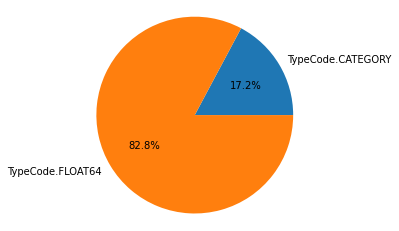

In [25]:
# Table schema pie chart.

type_counts = {}
for column_spec in column_specs.values():
  type_name = data_types.TypeCode(column_spec.data_type.type_code)
  type_counts[type_name] = type_counts.get(type_name, 0) + 1
    
plt.pie(x=type_counts.values(), labels=type_counts.keys(), autopct='%1.1f%%')
plt.axis('equal')
plt.show()

## **Update dataset: assign a label column and enable nullable columns**
This section is important, as it is where you specify which column (meaning which feature) you will use as your label. This label feature will then be predicted using all other features in the row.

AutoML Tables automatically detects your data column type. Depending on the type of your label column, AutoML Tables chooses to run a classification or regression model. If your label column contains only numerical values, but they represent categories, change your label column type to categorical by updating your schema.

It is important to note that deprecations in the DataType api cause the TypeCode (numeric code for each type) to be known. You can refer to those codes [here]( https://googleapis.dev/python/automl/latest/_modules/google/cloud/automl_v1beta1/types/data_types.html)










### **Update a column: Set nullable parameter**

In [34]:
column_spec_display_name = 'label' #@param {type:'string'}
type_code='CATEGORY' #@param {type:'string'}

update_column_response = tables_client.update_column_spec(
    dataset=dataset,
    column_spec_display_name=column_spec_display_name,
    #change typecode from name (CATEGORY) to its key (10): https://googleapis.dev/python/automl/latest/_modules/google/cloud/automl_v1beta1/types/data_types.html
    type_code=10,
    nullable=False,
)
update_column_response

name: "projects/887578167092/locations/us-central1/datasets/TBL1145124317898473472/tableSpecs/5939645376129662976/columnSpecs/3983831343862644736"
data_type {
  type_code: CATEGORY
}
display_name: "label"
data_stats {
  distinct_value_count: 10
  category_stats {
    top_category_stats {
      value: "1"
      count: 6652
    }
    top_category_stats {
      value: "7"
      count: 6052
    }
    top_category_stats {
      value: "3"
      count: 5942
    }
    top_category_stats {
      value: "0"
      count: 5879
    }
    top_category_stats {
      value: "2"
      count: 5872
    }
    top_category_stats {
      value: "6"
      count: 5864
    }
    top_category_stats {
      value: "4"
      count: 5760
    }
    top_category_stats {
      value: "8"
      count: 5760
    }
    top_category_stats {
      value: "9"
      count: 5756
    }
    top_category_stats {
      value: "5"
      count: 5333
    }
  }
  valid_value_count: 58870
}
etag: "AB3BwFolzWfr05_UwRZ21m9xieMlWEZprrzI

**Tip:** You can use `'type_code': 'CATEGORY'` in the preceding `update_column_spec_dict` to convert the column data type from `FLOAT64 to CATEGORY`.

### **Update dataset: Assign a label**

In [35]:
column_spec_display_name = 'label' #@param {type:'string'}

update_dataset_response = tables_client.set_target_column(
    dataset=dataset,
    column_spec_display_name=column_spec_display_name,
)
update_dataset_response

name: "projects/887578167092/locations/us-central1/datasets/TBL1145124317898473472"
display_name: "mnist"
create_time {
  seconds: 1638195749
  nanos: 53108000
}
etag: "AB3BwFp2XTuIV29V8V4VCCK6ODx4GhDKPpB_HPCFLwM3ABZeOO9weX4KZikOv913pIqC"
example_count: 58870
tables_dataset_metadata {
  primary_table_spec_id: "5939645376129662976"
  target_column_spec_id: "3983831343862644736"
  stats_update_time {
    seconds: 1638196038
    nanos: 306218000
  }
}

## **Creating a model**

### **Train a Model**

Once we have defined our datasets and features we will create a model.

Specify the duration of the training. For example, `'train_budget_milli_node_hours': 1000` runs the training for one hour. You can increase that number up to a maximum of 72 hours `('train_budget_milli_node_hours': 72000)` for the best model performance.

Even with a budget of 1 node hour (the minimum possible budget), training a model can take more than the specified node hours

If your Colab times out, use `client.list_models()` to check whether your model has been created. Then use model name to continue to the next steps. Run the following command to retrieve your model.

    model = tables_client.get_model(model_display_name=MODEL_DISPLAY_NAME)

You can also select the objective to optimize your model training by setting optimization_objective. This solution optimizes the model by using default optimization objective. Refer [link](https://cloud.google.com/automl-tables/docs/train#opt-obj) for more details. 

In [39]:
# The number of hours to train the model.
model_train_hours = 1 #@param {type:'integer'}

create_model_response = tables_client.create_model(
    model_display_name=MODEL_DISPLAY_NAME,
    dataset=dataset,
    train_budget_milli_node_hours=model_train_hours*1000,
    exclude_column_spec_names=['label'],
    optimization_objective = 'MINIMIZE_LOG_LOSS',
)

operation_id = create_model_response.operation.name

print('Create model operation: {}'.format(create_model_response.operation))

Create model operation: name: "projects/887578167092/locations/us-central1/operations/TBL9044801727777210368"
metadata {
  type_url: "type.googleapis.com/google.cloud.automl.v1beta1.OperationMetadata"
  value: "\032\014\010\304\334\223\215\006\020\240\211\273\315\001\"\014\010\304\334\223\215\006\020\240\211\273\315\001R\000"
}



In [40]:
# Wait until model training is done.
model = create_model_response.result()
model_name = model.name
model

name: "projects/887578167092/locations/us-central1/models/TBL7232831579091894272"


A neat link going over model logging, training and hyperparmeters can be found [here](https://cloud.google.com/automl-tables/docs/train#opt-obj)



## **Model deployment**

**Important :** Deploy the model, then wait until the model FINISHES deployment.

The model takes a while to deploy online. When the deployment code `response = client.deploy_model(model_name=model.name)` finishes, you will be able to see this on the UI. Check the [UI](https://console.cloud.google.com/automl-tables?_ga=2.255483016.-1079099924.1550856636) and navigate to the predict tab of your model, and then to the online prediction portion, to see when it finishes online deployment before running the prediction cell.You should see "online prediction" text near the top, click on it, and it will take you to a view of your online prediction interface. You should see "model deployed" on the far right of the screen if the model is deployed, or a "deploying model" message if it is still deploying. </span>

In [41]:
tables_client.deploy_model(model=model).result()

Verify if model has been deployed, check deployment_state field, it should show: DEPLOYED

In [42]:
model = tables_client.get_model(model_name=model_name)
model

name: "projects/887578167092/locations/us-central1/models/TBL7232831579091894272"
display_name: "mnist_image_classification_model"
dataset_id: "TBL1145124317898473472"
create_time {
  seconds: 1638198852
  nanos: 430884000
}
deployment_state: DEPLOYED
update_time {
  seconds: 1638208283
  nanos: 98065000
}
tables_model_metadata {
  target_column_spec {
    name: "projects/887578167092/locations/us-central1/datasets/TBL1145124317898473472/tableSpecs/5939645376129662976/columnSpecs/3983831343862644736"
    data_type {
      type_code: CATEGORY
    }
    display_name: "label"
  }
  input_feature_column_specs {
    name: "projects/887578167092/locations/us-central1/datasets/TBL1145124317898473472/tableSpecs/5939645376129662976/columnSpecs/4677385686477701120"
    data_type {
      type_code: CATEGORY
    }
    display_name: "1"
  }
  input_feature_column_specs {
    name: "projects/887578167092/locations/us-central1/datasets/TBL1145124317898473472/tableSpecs/5939645376129662976/columnSpecs

Run the prediction, only after the model finishes deployment

## **Batch prediction**

**Initialize prediction**

Your data source for batch prediction can be GCS or BigQuery.Create a GCS bucket and upload the file into your bucket.

 The AutoML Tables logs the errors in the `errors.csv` file. Also, enter the UI and create the bucket into which you will load your predictions.

The bucket's default name here is `automl-tables-pred` to be replaced with your own.

**NOTE:** The client library has a bug. If the following cell returns a:

`TypeError: Could not convert Any to BatchPredictResult` error, ignore it.

The batch prediction output file(s) will be updated to the GCS bucket that you set in the preceding cells.

Documentation for batch predictions [here](https://cloud.google.com/automl-tables/docs/predict-batch#automl-tables-example-python)

In [47]:
gcs_output_folder_name = 'mnist_test_predictions' #@param {type: 'string'}

SAMPLE_INPUT = 'gs://cml-project-bucket/mnist_test_pytorch.csv'
GCS_BATCH_PREDICT_OUTPUT = 'gs://{}/{}/'.format(BUCKET_NAME,
                                                gcs_output_folder_name)

! gsutil cp $SAMPLE_INPUT $GCS_BATCH_PREDICT_OUTPUT
GCS_BATCH_PREDICT_URI = 'gs://cml-project-bucket/mnist_test_pytorch.csv'


Copying gs://cml-project-bucket/mnist_test_pytorch.csv [Content-Type=text/csv]...
/ [1 files][ 38.8 MiB/ 38.8 MiB]                                                
Operation completed over 1 objects/38.8 MiB.                                     


Launch Batch prediction

In [48]:
batch_predict_response = tables_client.batch_predict(
    model=model, 
    gcs_input_uris=GCS_BATCH_PREDICT_URI,
    gcs_output_uri_prefix=GCS_BATCH_PREDICT_OUTPUT,
)
print('Batch prediction operation: {}'.format(
    batch_predict_response.operation))

# Wait until batch prediction is done.
batch_predict_result = batch_predict_response.result()
batch_predict_response.metadata

Batch prediction operation: name: "projects/887578167092/locations/us-central1/operations/TBL6481972064826687488"
metadata {
  type_url: "type.googleapis.com/google.cloud.automl.v1beta1.OperationMetadata"
  value: "\032\014\010\253\261\224\215\006\020\270\262\301\213\002\"\014\010\253\261\224\215\006\020\270\262\301\213\002\202\0014\n2\n0\n.gs://cml-project-bucket/mnist_test_pytorch.csv"
}



create_time {
  seconds: 1638209707
  nanos: 561011000
}
update_time {
  seconds: 1638210247
  nanos: 933088000
}
batch_predict_details {
  input_config {
    gcs_source {
      input_uris: "gs://cml-project-bucket/mnist_test_pytorch.csv"
    }
  }
  output_info {
    gcs_output_directory: "gs://cml-project-bucket/mnist_test_predictions/prediction-mnist_image_classification_model-2021-11-29T18:15:07.521513Z"
  }
}

# Test on adversarial data

We test on two values of epsilon-1.5 and 3


In [61]:
gcs_output_folder_name = 'mnist_adv15_predictions' #@param {type: 'string'}

SAMPLE_INPUT = 'gs://cml-project-bucket/adv_examples_15_gcp.csv'
GCS_BATCH_PREDICT_OUTPUT = 'gs://{}/{}/'.format(BUCKET_NAME,
                                                gcs_output_folder_name)

! gsutil cp $SAMPLE_INPUT $GCS_BATCH_PREDICT_OUTPUT
GCS_BATCH_PREDICT_URI = 'gs://cml-project-bucket/adv_examples_15_gcp.csv'

Copying gs://cml-project-bucket/adv_examples_15_gcp.csv [Content-Type=text/csv]...
/ [1 files][ 17.4 MiB/ 17.4 MiB]                                                
Operation completed over 1 objects/17.4 MiB.                                     


In [62]:
batch_predict_response = tables_client.batch_predict(
    model=model, 
    gcs_input_uris=GCS_BATCH_PREDICT_URI,
    gcs_output_uri_prefix=GCS_BATCH_PREDICT_OUTPUT,
)
print('Batch prediction operation: {}'.format(
    batch_predict_response.operation))

# Wait until batch prediction is done.
batch_predict_result = batch_predict_response.result()
batch_predict_response.metadata

Batch prediction operation: name: "projects/887578167092/locations/us-central1/operations/TBL1922077442114060288"
metadata {
  type_url: "type.googleapis.com/google.cloud.automl.v1beta1.OperationMetadata"
  value: "\032\014\010\332\305\224\215\006\020\200\376\321\313\003\"\014\010\332\305\224\215\006\020\200\376\321\313\003\202\0015\n3\n1\n/gs://cml-project-bucket/adv_examples_15_gcp.csv"
}



create_time {
  seconds: 1638212314
  nanos: 963936000
}
update_time {
  seconds: 1638212946
  nanos: 901092000
}
batch_predict_details {
  input_config {
    gcs_source {
      input_uris: "gs://cml-project-bucket/adv_examples_15_gcp.csv"
    }
  }
  output_info {
    gcs_output_directory: "gs://cml-project-bucket/mnist_adv15_predictions/prediction-mnist_image_classification_model-2021-11-29T18:58:34.925528Z"
  }
}

In [59]:
gcs_output_folder_name = 'mnist_adv30_predictions' #@param {type: 'string'}

SAMPLE_INPUT = 'gs://cml-project-bucket/adv_examples_30_gcp.csv'
GCS_BATCH_PREDICT_OUTPUT = 'gs://{}/{}/'.format(BUCKET_NAME,
                                                gcs_output_folder_name)

! gsutil cp $SAMPLE_INPUT $GCS_BATCH_PREDICT_OUTPUT
GCS_BATCH_PREDICT_URI = 'gs://cml-project-bucket/adv_examples_30_gcp.csv'

Copying gs://cml-project-bucket/adv_examples_30_gcp.csv [Content-Type=text/csv]...
/ [1 files][ 52.4 MiB/ 52.4 MiB]                                                
Operation completed over 1 objects/52.4 MiB.                                     


In [60]:
batch_predict_response = tables_client.batch_predict(
    model=model, 
    gcs_input_uris=GCS_BATCH_PREDICT_URI,
    gcs_output_uri_prefix=GCS_BATCH_PREDICT_OUTPUT,
)
print('Batch prediction operation: {}'.format(
    batch_predict_response.operation))

# Wait until batch prediction is done.
batch_predict_result = batch_predict_response.result()
batch_predict_response.metadata

Batch prediction operation: name: "projects/887578167092/locations/us-central1/operations/TBL2318394209322663936"
metadata {
  type_url: "type.googleapis.com/google.cloud.automl.v1beta1.OperationMetadata"
  value: "\032\013\010\257\276\224\215\006\020\210\225\310g\"\013\010\257\276\224\215\006\020\210\225\310g\202\0015\n3\n1\n/gs://cml-project-bucket/adv_examples_30_gcp.csv"
}



create_time {
  seconds: 1638211375
  nanos: 217189000
}
update_time {
  seconds: 1638211980
  nanos: 768715000
}
batch_predict_details {
  input_config {
    gcs_source {
      input_uris: "gs://cml-project-bucket/adv_examples_30_gcp.csv"
    }
  }
  output_info {
    gcs_output_directory: "gs://cml-project-bucket/mnist_adv30_predictions/prediction-mnist_image_classification_model-2021-11-29T18:42:55.183481Z"
  }
}

## Checking predictions
If you specified Cloud Storage as your output destination, the results of your batch prediction request are returned as CSV files in a new folder in the bucket you specified. The name of the folder is the name of your model, prepended with "prediction-" and appended with the timestamp of when the prediction job started. You can find the Cloud Storage folder name in Recent predictions at the bottom of the Batch prediction page of the Test & Use tab for your model.

The Cloud Storage folder contains two types of files: error files and prediction files. If the results are large, additional files are created.

The error files are named errors_1.csv, errors_2.csv, and so on. They contain a header row, and a row for every row in your prediction request for which AutoML Tables could not return a prediction.

The prediction files are named tables_1.csv, tables_2.csv, and so on. They contain a header row with the column names, and a row for every prediction returned.

In the prediction files, AutoML Tables returns your prediction data, and creates one or more new columns for the prediction results, depending on your model type:

Classification:

For each potential value of your target column, a column named <target-column-name>_<value>_score is added to the results. This column contains the score, or confidence estimate, for that value.
    
I download and upload the predictions here for viewing

In [63]:
import pandas as pd
test_predictions = pd.read_csv('mnist_test_predictions_prediction-mnist_image_classification_model-2021-11-29T18_15_07.521513Z_tables_1.csv')

In [64]:
test_predictions.head()

,label,1,2,3,4,5,6,7,8,9,...,label_1_score,label_7_score,label_3_score,label_0_score,label_2_score,label_6_score,label_4_score,label_8_score,label_9_score,label_5_score
0,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000042,0.000059,0.000076,0.000058,0.000180,0.998739,0.000177,0.000276,0.000128,0.000266
1,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010941,0.005737,0.020158,0.000552,0.001144,0.000482,0.024135,0.027317,0.896730,0.012805
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004420,0.008049,0.879280,0.000828,0.001056,0.000939,0.001454,0.006095,0.019253,0.078626
3,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000139,0.001419,0.000451,0.000067,0.000091,0.000066,0.003475,0.000814,0.992655,0.000824
4,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000465,0.000677,0.001602,0.042420,0.005500,0.942992,0.001347,0.001039,0.000787,0.003172


In [76]:
def getPredictions(string):
    return string.split('_')[1]

def findPredictions(test_predictions, filename):
    score_column_names = ['label_1_score','label_7_score','label_3_score','label_0_score','label_2_score','label_6_score','label_4_score','label_8_score','label_9_score','label_5_score']
    test_predictions['Predicted_Label_String'] = test_predictions[score_column_names].idxmax(axis=1)
    test_predictions = test_predictions[test_predictions['Predicted_Label_String'].notna()]                     
    test_predictions['Predicted_label'] = test_predictions['Predicted_Label_String'].apply(getPredictions)  
    test_predictions.to_csv(filename, header=True, index= False)                      
    return test_predictions

In [77]:
test_predictions = findPredictions(test_predictions, 'mnist_test_scored_pred.csv')

In [78]:
test_predictions.head()

,label,1,2,3,4,5,6,7,8,9,...,label_3_score,label_0_score,label_2_score,label_6_score,label_4_score,label_8_score,label_9_score,label_5_score,Predicted_Label_String,Predicted_label
0,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000076,0.000058,0.000180,0.998739,0.000177,0.000276,0.000128,0.000266,label_6_score,6
1,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.020158,0.000552,0.001144,0.000482,0.024135,0.027317,0.896730,0.012805,label_9_score,9
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.879280,0.000828,0.001056,0.000939,0.001454,0.006095,0.019253,0.078626,label_3_score,3
3,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000451,0.000067,0.000091,0.000066,0.003475,0.000814,0.992655,0.000824,label_9_score,9
4,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001602,0.042420,0.005500,0.942992,0.001347,0.001039,0.000787,0.003172,label_6_score,6


## Find Accuracy on Test Data

In [84]:
import numpy as np
def findAcc(true_label_series, predicted_label_series):
    correct = np.array(pd.to_numeric(true_label_series) == pd.to_numeric(predicted_label_series))
    return np.count_nonzero(correct)/correct.size



In [85]:
findAcc(test_predictions['label'], test_predictions['Predicted_label'])

0.9863404689092763

# Check performance of Adversary
### Epsilon = 0.15

In [86]:
adv_15_pred = pd.read_csv('mnist_adv15_predictions_prediction-mnist_image_classification_model-2021-11-29T18_58_34.925528Z_tables_1.csv')
adv_15_pred.head()

,1,2,3,4,5,6,7,8,9,10,...,label_7_score,label_3_score,label_0_score,label_2_score,label_6_score,label_4_score,label_8_score,label_9_score,label_5_score,true_label
0,0.00,0.00,0.00,0.15,0.00,0.00,0.00,0.15,0.15,0.15,...,0.269820,0.104654,0.001641,0.046950,0.042241,0.000976,0.373463,0.000861,0.044118,1
1,0.15,0.00,0.15,0.15,0.00,0.00,0.00,0.00,0.00,0.00,...,0.001686,0.085190,0.024605,0.284166,0.521452,0.006447,0.020968,0.009710,0.043499,5
2,0.15,0.00,0.15,0.00,0.15,0.15,0.00,0.00,0.00,0.00,...,0.283534,0.121642,0.071308,0.038359,0.128032,0.030094,0.152633,0.091601,0.075425,3
3,0.00,0.15,0.00,0.15,0.15,0.15,0.15,0.15,0.15,0.15,...,0.095835,0.262050,0.014247,0.063708,0.001921,0.005397,0.354119,0.063718,0.105614,5
4,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.00,...,0.248432,0.209370,0.025292,0.015226,0.129604,0.008049,0.240361,0.072099,0.050246,3


In [87]:
adv_15_pred = findPredictions( adv_15_pred, 'adv_15_scored_pred.csv')

In [89]:
findAcc(adv_15_pred['true_label'], adv_15_pred['Predicted_label'])

0.18063002680965148

### Epsilon = 0.3

In [90]:
adv_30_pred = pd.read_csv('mnist_adv30_predictions_prediction-mnist_image_classification_model-2021-11-29T18_42_55.183481Z_tables_1.csv')
adv_30_pred.head()

,1,2,3,4,5,6,7,8,9,10,...,label_7_score,label_3_score,label_0_score,label_2_score,label_6_score,label_4_score,label_8_score,label_9_score,label_5_score,true_label
0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.0,...,0.124545,0.053113,0.056658,0.330118,0.286345,0.041437,0.020801,0.002190,0.043670,5
1,0.3,0.3,0.3,0.3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.164736,0.062310,0.063783,0.058654,0.119258,0.186377,0.180637,0.010687,0.149951,8
2,0.0,0.0,0.0,0.0,0.3,0.3,0.0,0.0,0.0,0.0,...,0.084020,0.129738,0.158759,0.087886,0.289211,0.052363,0.106490,0.004790,0.084905,2
3,0.3,0.3,0.3,0.3,0.3,0.0,0.3,0.3,0.0,0.0,...,0.260950,0.025053,0.104264,0.128446,0.182150,0.035588,0.100664,0.124299,0.036346,3
4,0.0,0.0,0.0,0.3,0.3,0.0,0.3,0.0,0.0,0.3,...,0.226609,0.222034,0.017216,0.010227,0.112216,0.009552,0.262360,0.046064,0.032962,3


In [91]:
adv_30 =findPredictions( adv_30_pred, 'adv_30_scored_pred.csv')

In [93]:
findAcc(adv_30['true_label'], adv_30['Predicted_label'])

0.10815345039704731

## **Cleaning up**

To clean up all GCP resources used in this project, you can [delete the GCP
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Undeploy the model

In [ ]:
undeploy_model_response = tables_client.undeploy_model(model=model)

In [ ]:
# # Delete model resource.
# tables_client.delete_model(model_name=model_name)

# # Delete dataset resource.
# tables_client.delete_dataset(dataset_name=dataset_name)

# # Delete Cloud Storage objects that were created.
# ! gsutil -m rm -r gs://$BUCKET_NAME
  
# # If training model is still running, cancel it.
# automl_client.transport._operations_client.cancel_operation(operation_id)  


## **Next steps**
Please follow latest updates on AutoML [here](https://cloud.google.com/automl/docs/).